In [2]:
 !pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 50.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import json
import torch
from torch import nn
from tqdm import tqdm
import faiss
import sqlite3
from transformers import BertModel, BertTokenizer

# For displaying thumbnail images
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [17]:
product_df = pd.read_csv('pet_supplies_products.csv')
product_df.head()

,Unnamed: 0,parent_asin,title,rating_number,features,description,combined_description,label
0,0,B0BTKL8P4X,Pawprints Pet Memorial Frame with Pawprints Le...,2950,['Beautiful dog memorial frame with a sentimen...,[],Beautiful dog memorial frame with a sentimenta...,34
1,1,B081W4G8K7,PetSafe Exterior / Interior Cat Door: Staywell...,2341,['PET SIZE: The large flap opening is perfect ...,['The PetSafe Staywell Big Cat/Small Dog Pet D...,The PetSafe Staywell Big CatSmall Dog Pet Door...,67
2,2,B0843HPZKY,ASPCA Cat House & Cat Scratcher w/Bonus Catnip...,9248,['Cardboard cat house 2 in 1 with scratching b...,['Give kitty a relaxing place to play and hide...,Give kitty a relaxing place to play and hide w...,73
3,3,B0BY8VXW1R,"BUUOC Dog Training Collar with Remote 2000Ft, ...",2208,['【3 Modes Train Dogs Like A Pro】 3 Safe effec...,[],3 Modes Train Dogs Like A Pro 3 Safe effective...,23
4,4,B08F73Y774,KOOLTAIL Basic Dog Hoodie - Soft and Warm Dog ...,5164,['Size:The Size of the dog sweater is L Neck G...,[],SizeThe Size of the dog sweater is L Neck Girt...,18


In [6]:
# Load in original data to add supplemental fields
file='meta_Pet_Supplies.jsonl'

products = []

with open(file, 'r') as fp:
    for line in fp:
        products.append(json.loads(line.strip()))

In [7]:
products[0]

{'main_category': 'Pet Supplies',
 'title': 'Hurtta Pet Collection 14-Inch Padded Y-Harness, Pink',
 'average_rating': 4.4,
 'rating_number': 166,
 'features': ['Made from highly durable Neoprene',
  'Fitted with efficient 3M reflectors for visibility',
  'Adjustable chest and comfortable for your dog',
  'Machine washable',
  'The padding stays in place when the dog is moving, providing protection from the clip buckle'],
 'description': ['Hurtta harnesses are suitable for active walks for all dogs, but they are especially recommended for dogs with back and neck problems. When the dog pulls on the leash, the close-fitting harness distributes pressure evenly across the chest, preventing damages to the dog’s vertebrae. Thanks to the wide padding and ergonomic design, the harness is comfortable and does not cause wear on the dog’s fur or skin. Easy and quick to put on, both dog and owner will get accustomed to the harness in no time.\xa0Made from durable Neoprene, the harnesses are fitted

In [8]:
# APPEND NEW FIELDS TO DATA BY CREATING DICTIONARY WHERE KEYS ARE PARENT_ASIN AND VALUES ARE COLUMN VALUES
extra_product_info = {product['parent_asin']: [product['average_rating'], product['rating_number'], product['images'][0]['thumb'] if (len(product['images']) > 0) and ('thumb' in product['images'][0]) else '', product['store']] for product in products}

In [9]:
extra_product_df = pd.DataFrame.from_dict(extra_product_info, orient="index")

In [10]:
extra_product_df.columns = ['average_rating', 'number_of_ratings', 'thumbnail_image_link', 'store']

In [11]:
extra_product_df.head()

,average_rating,number_of_ratings,thumbnail_image_link,store
B00XJG2SLG,4.4,166,https://m.media-amazon.com/images/I/51t7obbDd+...,Hurtta
B0BD6TXL2G,4.6,100,https://m.media-amazon.com/images/I/31r9jsuUe0...,FIVEAGE
B01MQTWB5H,4.4,84,https://m.media-amazon.com/images/I/31T4ekKFOr...,Encompass All
B07DYM6LXD,4.5,348,https://m.media-amazon.com/images/I/51ZLo1hIan...,SlowTon
B09ZTMTS6N,4.4,130,https://m.media-amazon.com/images/I/41y1zgIZtG...,Mewoo


In [18]:
product_df = product_df.set_index('parent_asin')

In [19]:
final_df = product_df.join(extra_product_df)

In [20]:
final_df.head()

,Unnamed: 0,title,rating_number,features,description,combined_description,label,average_rating,number_of_ratings,thumbnail_image_link,store
parent_asin,,,,,,,,,,,
B0BTKL8P4X,0,Pawprints Pet Memorial Frame with Pawprints Le...,2950,['Beautiful dog memorial frame with a sentimen...,[],Beautiful dog memorial frame with a sentimenta...,34,4.9,2950,https://m.media-amazon.com/images/I/4129I+nWIK...,Pawprints Left by You Memorial Gifts
B081W4G8K7,1,PetSafe Exterior / Interior Cat Door: Staywell...,2341,['PET SIZE: The large flap opening is perfect ...,['The PetSafe Staywell Big Cat/Small Dog Pet D...,The PetSafe Staywell Big CatSmall Dog Pet Door...,67,4.5,2341,https://m.media-amazon.com/images/I/51-hlTor14...,PetSafe
B0843HPZKY,2,ASPCA Cat House & Cat Scratcher w/Bonus Catnip...,9248,['Cardboard cat house 2 in 1 with scratching b...,['Give kitty a relaxing place to play and hide...,Give kitty a relaxing place to play and hide w...,73,4.7,9248,https://m.media-amazon.com/images/I/51mzNkN6LF...,ASPCA
B0BY8VXW1R,3,"BUUOC Dog Training Collar with Remote 2000Ft, ...",2208,['【3 Modes Train Dogs Like A Pro】 3 Safe effec...,[],3 Modes Train Dogs Like A Pro 3 Safe effective...,23,4.5,2208,https://m.media-amazon.com/images/I/51fkxAd5d1...,BUUOC
B08F73Y774,4,KOOLTAIL Basic Dog Hoodie - Soft and Warm Dog ...,5164,['Size:The Size of the dog sweater is L Neck G...,[],SizeThe Size of the dog sweater is L Neck Girt...,18,4.3,5164,https://m.media-amazon.com/images/I/51JOe-+ENy...,KOOLTAIL


In [21]:
# Save final df
final_df.to_csv("final_pet_products_df.csv", index=True)

In [36]:
# In the future, we can now simply read in this data frame rather than reproducing it every time
final_df = pd.read_csv("final_pet_products_df.csv", index_col='parent_asin')

In [37]:
final_df.head()

,Unnamed: 0,title,rating_number,features,description,combined_description,label,average_rating,number_of_ratings,thumbnail_image_link,store
parent_asin,,,,,,,,,,,
B0BTKL8P4X,0,Pawprints Pet Memorial Frame with Pawprints Le...,2950,['Beautiful dog memorial frame with a sentimen...,[],Beautiful dog memorial frame with a sentimenta...,34,4.9,2950,https://m.media-amazon.com/images/I/4129I+nWIK...,Pawprints Left by You Memorial Gifts
B081W4G8K7,1,PetSafe Exterior / Interior Cat Door: Staywell...,2341,['PET SIZE: The large flap opening is perfect ...,['The PetSafe Staywell Big Cat/Small Dog Pet D...,The PetSafe Staywell Big CatSmall Dog Pet Door...,67,4.5,2341,https://m.media-amazon.com/images/I/51-hlTor14...,PetSafe
B0843HPZKY,2,ASPCA Cat House & Cat Scratcher w/Bonus Catnip...,9248,['Cardboard cat house 2 in 1 with scratching b...,['Give kitty a relaxing place to play and hide...,Give kitty a relaxing place to play and hide w...,73,4.7,9248,https://m.media-amazon.com/images/I/51mzNkN6LF...,ASPCA
B0BY8VXW1R,3,"BUUOC Dog Training Collar with Remote 2000Ft, ...",2208,['【3 Modes Train Dogs Like A Pro】 3 Safe effec...,[],3 Modes Train Dogs Like A Pro 3 Safe effective...,23,4.5,2208,https://m.media-amazon.com/images/I/51fkxAd5d1...,BUUOC
B08F73Y774,4,KOOLTAIL Basic Dog Hoodie - Soft and Warm Dog ...,5164,['Size:The Size of the dog sweater is L Neck G...,[],SizeThe Size of the dog sweater is L Neck Girt...,18,4.3,5164,https://m.media-amazon.com/images/I/51JOe-+ENy...,KOOLTAIL


Let's try testing our model with only the products that were successfully classified by BerTopic.

In [38]:
final_df = final_df.loc[final_df['label'] != -1]

In [7]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [8]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [10]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
query_encoder.load_state_dict(torch.load("pet_products_query_encoder_v3.pt"))

description_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
description_encoder.load_state_dict(torch.load("pet_products_description_encoder_v3.pt"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-10-1a57587d782b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  query_encoder.load_state_dict(torch.load("pet_products_query_encoder_v3.pt"))
<ipython-input

<All keys matched successfully>

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
product_descriptions = list(final_df['description'])
product_ids = list(final_df.index)
batch_size=128
description_encoder = description_encoder.to(device)

sample_tokens = tokenizer(
    product_descriptions[0:1],
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

with torch.no_grad():
    sample_embedding = description_encoder(sample_tokens)
embedding_dim = sample_embedding.shape[1]

# Create FAISS index based on requested type
index = faiss.IndexFlatIP(embedding_dim)

# Encode all products in batches and add to index
print("Encoding products and adding to index...")
batch_product_ids = []

# Create batches for product descriptions
batches = [product_descriptions[i:i + batch_size] for i in range(0, len(product_descriptions), batch_size)]
batch_ids = [product_ids[i:i + batch_size] for i in range(0, len(product_ids), batch_size)]

for batch_desc, batch_id in tqdm(zip(batches, batch_ids), total=len(batches), desc="Building index"):
    tokens = tokenizer(
        batch_desc,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    )

    # Encode batch
    with torch.no_grad():
        embeddings = description_encoder(tokens)
        # Normalize embeddings for cosine similarity
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    # Add to index
    index.add(embeddings.cpu().numpy())
    batch_product_ids.extend(batch_id)

print(f"Index built with {len(batch_product_ids)} products")

Encoding products and adding to index...


Building index: 100%|██████████| 85/85 [01:17<00:00,  1.10it/s]

Index built with 10842 products


In [13]:
faiss.write_index(index, "pet_product_embeddings_v3.index")

In [14]:
# Create SQL Connection
conn = sqlite3.connect("pet_product_embeddings.db")
cursor = conn.cursor()

In [16]:
final_df.head()

,Unnamed: 0,title,rating_number,features,description,combined_description,label,average_rating,number_of_ratings,thumbnail_image_link,store
parent_asin,,,,,,,,,,,
B0BTKL8P4X,0,Pawprints Pet Memorial Frame with Pawprints Le...,2950,['Beautiful dog memorial frame with a sentimen...,[],Beautiful dog memorial frame with a sentimenta...,34,4.9,2950,https://m.media-amazon.com/images/I/4129I+nWIK...,Pawprints Left by You Memorial Gifts
B081W4G8K7,1,PetSafe Exterior / Interior Cat Door: Staywell...,2341,['PET SIZE: The large flap opening is perfect ...,['The PetSafe Staywell Big Cat/Small Dog Pet D...,The PetSafe Staywell Big CatSmall Dog Pet Door...,67,4.5,2341,https://m.media-amazon.com/images/I/51-hlTor14...,PetSafe
B0843HPZKY,2,ASPCA Cat House & Cat Scratcher w/Bonus Catnip...,9248,['Cardboard cat house 2 in 1 with scratching b...,['Give kitty a relaxing place to play and hide...,Give kitty a relaxing place to play and hide w...,73,4.7,9248,https://m.media-amazon.com/images/I/51mzNkN6LF...,ASPCA
B0BY8VXW1R,3,"BUUOC Dog Training Collar with Remote 2000Ft, ...",2208,['【3 Modes Train Dogs Like A Pro】 3 Safe effec...,[],3 Modes Train Dogs Like A Pro 3 Safe effective...,23,4.5,2208,https://m.media-amazon.com/images/I/51fkxAd5d1...,BUUOC
B08F73Y774,4,KOOLTAIL Basic Dog Hoodie - Soft and Warm Dog ...,5164,['Size:The Size of the dog sweater is L Neck G...,[],SizeThe Size of the dog sweater is L Neck Girt...,18,4.3,5164,https://m.media-amazon.com/images/I/51JOe-+ENy...,KOOLTAIL


In [39]:
final_df["id"] = final_df.index

In [56]:
final_df_f = final_df[['title', 'combined_description', 'rating_number', 'average_rating', 'thumbnail_image_link', 'store']]

In [ ]:
final_df_f.head()

In [57]:
# CREATE SQL TABLE
cursor.execute("DROP TABLE IF EXISTS products")

cursor.execute("""
    CREATE TABLE products (
        id TEXT PRIMARY KEY,
        product_name TEXT,
        seller TEXT,
        product_description TEXT,
        num_ratings INTEGER,
        avg_rating REAL,
        image_link TEXT
    )
    """)
conn.commit()

# POPULATE SQL TABLE WITH PRODUCT DATA
for row in final_df_f.itertuples(index=True, name=None):
    prod_id, prod_name, prod_desc, num_rating, avg_rating, image_url, store = row
    cursor.execute(
        """INSERT OR REPLACE INTO products
        (id, product_name, seller, product_description, num_ratings, avg_rating, image_link) VALUES (?, ?, ?, ?, ?, ?, ?)""",
        (prod_id, prod_name, store, prod_desc, num_rating, avg_rating, image_url)
    )
conn.commit()

In [58]:
res = cursor.execute("SELECT * FROM products LIMIT 1")
res.fetchall()

[('B0BTKL8P4X',
  'Pawprints Pet Memorial Frame with Pawprints Left by You Poem - Touching Dog Sympathy Gift for Pet Loss Remembrance (Frame with Ash Vial)',
  'Pawprints Left by You Memorial Gifts',
  'Beautiful dog memorial frame with a sentimental sympathy poem to help a grieving friend or loved one remember a special pet Frame comes with an attached ribbon with an ash vial and holds a 5x7 photo of that special companion who has crossed the rainbow bridge Stainless steel vial with red engraved heart measures 175 and can hold ashes pet hair dried flowers or other similar remembrance of pet Remember your beloved pet with this 5x7 black hinged table frame that can displayed anywhere in home or office The heartfelt Pawprints Left By You copyright Teri Harrison poem perfectly states the feeling of someone who lost their loyal companion and will provide comfort to the recipient in the time of grieving A special pet loss sympathy gift that lasts longer than flowers and will keep the lost c

In [59]:
def search(query, product_embeddings, k=10):
    query_tokens = tokenizer(
        query,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=32
    )

    with torch.no_grad():
        query_embedding = query_encoder(query_tokens)
        query_embedding = torch.nn.functional.normalize(query_embedding, p=2, dim=1)

    similarities, indices = product_embeddings.search(query_embedding.cpu().numpy(), k)

    similarities = similarities.reshape(-1)
    indices = indices.reshape(-1)
    top_product_ids = list(final_df_f.index[indices])

    placeholders = ', '.join(['?'] * len(top_product_ids))
    query = f"SELECT id, product_name, product_description, seller, image_link FROM products WHERE id IN ({placeholders})"
    res = cursor.execute(query, top_product_ids)
    query_results = res.fetchall()

    results = [{
        'product_id': query_result[0],
        'product_name': query_result[1],
        'product_description': query_result[2],
        'seller': query_result[3],
        'image_url': query_result[4],
        'similarity_score': similarity
    } for query_result, similarity in zip(query_results, similarities)]

    return results

In [63]:
# Read in index
index = faiss.read_index("pet_product_embeddings_v3.index")

Queries that work well: "Enriched dog food", "Fish water purifier for tank", "keep dog close by on walk", "cat litter box for waste"

In [82]:
search_results = search("enriched dog food", index)

Product Name: Hill's Science Diet Wet Dog Food, Adult 1-6, Beef & Barley Entrée, 13 Ounce (Pack of 12)
Product Description: Product Description Give your grown dog the premium nutrition they deserve with Hills Science Diet adult beef  Barley entre dog food This Canned adult dog food made with natural ingredients is a delicious way to provide precisely balanced nutrition and support the Overall health and wellbeing of your pet Purposely made with easily digestible ingredients this Canned pet food supports your adult dogs skin and coat with omega6 fatty acids and vitamin E while the highquality protein from real beef h


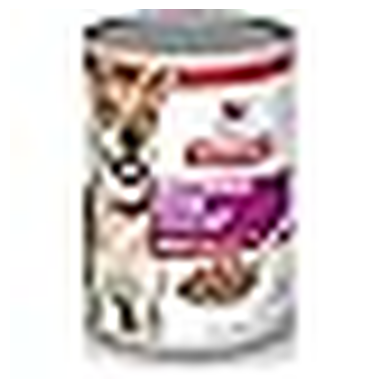

Product Name: PEDIGREE PUPPY Soft Wet Dog Food Morsels in Sauce With Chicken, 3.5 oz Pouches, 16 Pack
Product Description: Formulated to help promote strong healthy teeth and bones PEDIGREE Puppy Morsels in Sauce with Chicken is the wet dog food specially designed to support growing puppies Made with real ingredients including tasty chicken your puppy will love this soft food as a treat topper as a mixer with dry puppy food or a complete meal Feed your puppy with confidence knowing that PEDIGREE dog food is made with DHA to help support brain development and the necessary vitamins and minerals for a complete and bal


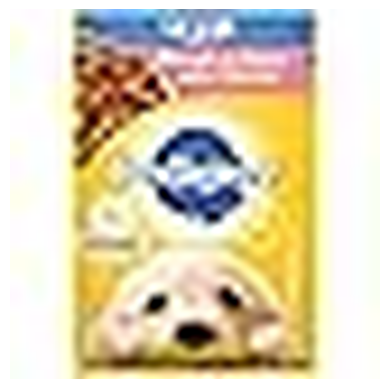

Product Name: PEDIGREE CHOPPED GROUND DINNER Puppy Canned Soft Wet Dog Food With Lamb & Rice, 13.2 oz. Cans (Pack of 12)
Product Description: PEDIGREE CHOPPED GROUND DINNER soft wet puppy food with lamb  rice is a tasty recipe specially prepared for growing puppies PEDIGREE Puppy food is formulated with DHA to help support your puppys brain development PEDIGREE dog food is made with real ingredients including lamb so that your furry friend can enjoy their food as a treat topper or complete meal You can serve this wet dog food alone or mix it into kibble for added flavor PEDIGREEs dog food is made with the necessary vitamins and minera


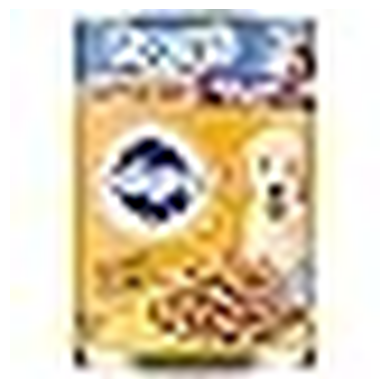

Product Name: Royal Canin Medium Breed Adult Dry Dog Food, 30 lb bag
Product Description: With countless dog food options out there that feature formulas focused on ingredients how do you know what nutrition is right for your pet No matter how big or small your dog is Royal Canin has a rightsized diet made with the precise amount of nutrients needed for every stage of their magnificent life Most mediumsized dogs are known for their seemingly endless energy Whether their favorite thing is swimming exploring or lots of walks theyre always on the go These pets need special nutritional s


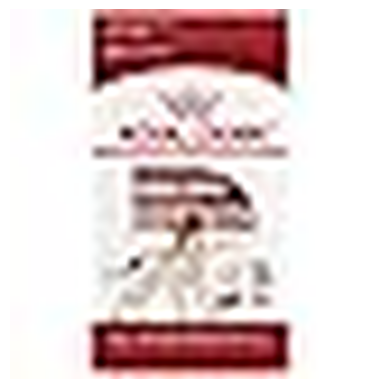

Product Name: Purebites Salmon Freeze Dried Dog Treats, 1.16Oz | 33G - Entry Size
Product Description: Go ahead turn the bag around and look at our ingredients PureBites are made with only 1 ingredient 100 Pure WildCaught  Made in USA Raw Human Grade Sockeye Salmon Dogs love the taste of PureBites because our treats are freeze dried RAW to lock in the aroma texture and freshness they crave Dog parents love PureBites because our treats are 100 pure and rich in nutrients for a happy and healthy life PureBites Salmon is proudly Sourced  Made in the USA with Human Grade Salmon and is high in protein 


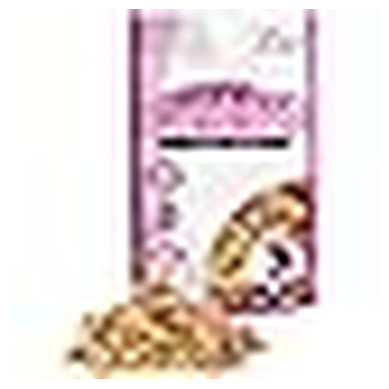

Product Name: Purina ONE Natural, High Protein Gravy Wet Dog Food, SmartBlend True Instinct Turkey & Game Bird - (12) 13 oz. Cans
Product Description: Feed your dogs true instinct to seek out nutrientdense foods when you serve Purina ONE SmartBlend True Instinct Tender Cuts in Gravy With Real Turkey  Game Bird adult wet dog food This premium dog food is made with real turkey and game bird giving you something to feel good about every time you fill his dish The tender cuts deliver a palatepleasing texture while the savory gravy adds flavor and moisture to every bite Your dog gets a highly digestible formula so more nutrition goes to work inside


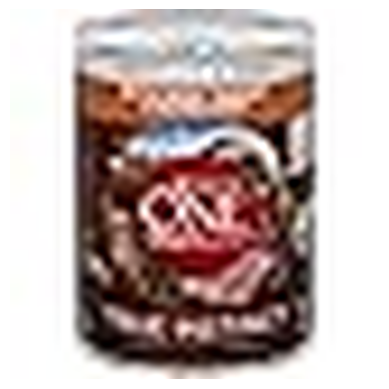

Product Name: Purina Beneful Dry Dog Food, Simple Goodness With Farm Raised Beef - (4) 12 ct. Boxes
Product Description: Satisfy your dogs taste buds with the flavorful morsels found in Purina Beneful Simple Goodness With FarmRaised Beef adult dry dog food Accents of real vegetables add variety to your dogs diet and real farmraised beef is the 1 ingredient in this recipe The tender meaty texture invites your dog to nibble his way to the bottom of his dish while the highquality ingredients give you something to feel good about every time you open a pouch Every serving delivers 100 complete and balanced nutrition fo


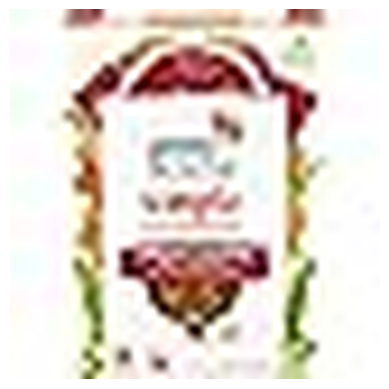

Product Name: Hill's Science Diet Senior 7+ Canned Dog Food, Savory Stew with Beef & Vegetables, 12.8 oz. Cans, 12-Pack
Product Description: Product Description Packed with highquality protein for lean muscle Hills Science Diet Adult 7 Savory Stew with Beef  Vegetables wet dog food combines delicious ingredients with precise nutrition to support older dogs in energy and activity level This mouthwatering canned dog food made with natural ingredients combines real beef and vegetables with a balanced set of minerals promote kidney and heart health Theres more to love with the new look of Science Diet Some of our products also have new n


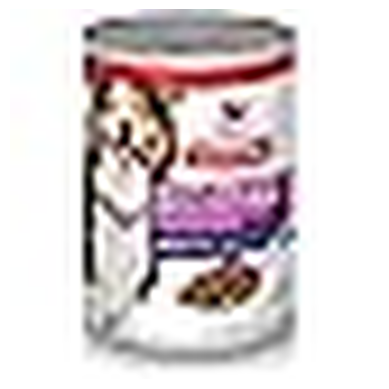

Product Name: Pedigree Choice Cuts in Gravy Adult Wet Dog Food Variety Packs, 3.5 Ounce - 18 Count (Pack of 2)
Product Description: PEDIGREE CHOICE CUTS IN GRAVY is the wet dog food that delivers the taste dogs crave with the nutrition they need This wet food variety pack features three delicious flavors Chicken Casserole Beef Noodles  Vegetable and Grilled Chicken These flavorful hearty cuts in a delectable gravy sauce make a tasty meal for adult dogs of all sizes and provide the perfect balance of vitamins and minerals with no artificial flavor no added sugar and no high fructose corn syrup Each recipe is 100 complete and 


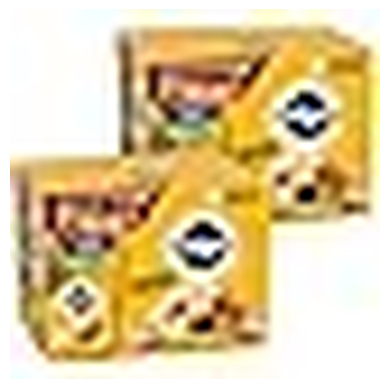

Product Name: Whole Earth Farms Grain Free Dog Food, Small Breed Recipe with Chicken and Turkey, Dry Dog Food - 12 lb. Bag
Product Description: Give your dog perfectly balanced nutrition from the farm with Whole Earth Farms Grain Free Small Breed Dog Food Chicken and Turkey Recipe Dry Dog Food This grain free dry dog food has highquality protein as the first ingredient and heart shaped kibble for a little love in every bowl Add in field grown vegetables for a small breed dog food with fiber vitamins and minerals This chicken dog food recipe is a real meat dog food packed with protein for strong muscles The Wholesome Harvest Blend in thi


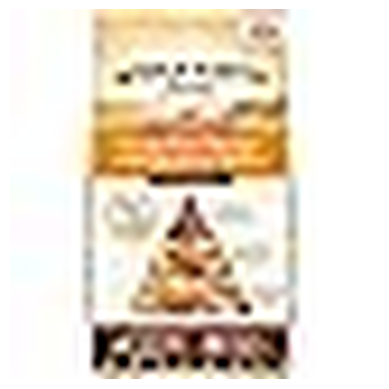

In [83]:
for result in search_results:
    try:
        # URL of the image
        image_url = result['image_url']

        # Fetch the image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        target_size = (1000, 1000)

        # Calculate the aspect ratio
        img_ratio = img.width / img.height
        target_ratio = target_size[0] / target_size[1]

        if img_ratio > target_ratio:
            # Scale based on width
            new_width = target_size[0]
            new_height = int(new_width / img_ratio)
        else:
            # Scale based on height
            new_height = target_size[1]
            new_width = int(new_height * img_ratio)

        # Resize the image while maintaining the aspect ratio
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        # Display the resized image
        plt.imshow(img_resized)
        plt.axis('off')  # Hide the axes
        plt.show()
    except:
        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        print("No product image provided")